# Settings

## Imports

In [0]:
%reset -f

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
% cd /gdrive/My\ Drive/Uni-Stra/Projet

/gdrive/My Drive/Uni-Stra/Projet


In [0]:
%ls

 annotations_trainval2017.zip   Landscapes_classification
 clouds/                       'Methods comparison.gsheet'
 Get_Data                       sample_submission.csv
'Image processing.ipynb'        stuff_annotations_trainval2017.zip
 imgs/                          train2017.zip
 intel_img/                     train.csv.zip
 kaggle.json                    val2017.zip


In [1]:
import os, os.path, shutil
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import re
import csv
import pywt

plt.style.use("default")

from keras import datasets
from keras import models
from keras import layers
from keras import optimizers
import IPython.display as display
from PIL import Image
from scipy import ndimage, misc

from keras.preprocessing.image import ImageDataGenerator


from pycocotools.coco import COCO


np.set_printoptions(linewidth=5000,precision=2)

Using TensorFlow backend.


In [0]:
tf.__version__

'1.15.0'

## COCO

### Get

In [0]:
!wget http://images.cocodataset.org/zips/train2017.zip

--2020-01-21 16:49:38--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.207.91
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.207.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  29.7MB/s    in 7m 41s  

2020-01-21 16:57:19 (40.0 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [0]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2020-01-21 16:57:25--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.164.251
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.164.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  7.13MB/s    in 98s     

2020-01-21 16:59:03 (7.97 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [0]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2020-01-21 17:00:38--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.27.116
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.27.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  9.26MB/s    in 32s     

2020-01-21 17:01:11 (7.51 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [0]:
!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip

--2020-01-21 17:01:13--  http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.130.107
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.130.107|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148688564 (1.1G) [application/zip]
Saving to: ‘stuff_annotations_trainval2017.zip’

stuff_annotations_t 100%[===================>]   1.07G  9.58MB/s    in 2m 8s   

2020-01-21 17:03:21 (8.58 MB/s) - ‘stuff_annotations_trainval2017.zip’ saved [1148688564/1148688564]



### Unzip

In [0]:
!unzip stuff_annotations_trainval2017.zip -d imgs

Archive:  stuff_annotations_trainval2017.zip
   creating: imgs/annotations/
 extracting: imgs/annotations/stuff_train2017_pixelmaps.zip  
 extracting: imgs/annotations/stuff_val2017_pixelmaps.zip  
  inflating: imgs/annotations/stuff_val2017.json  
  inflating: imgs/annotations/stuff_train2017.json  
   creating: imgs/annotations/deprecated-challenge2017/
  inflating: imgs/annotations/deprecated-challenge2017/val-ids.txt  
  inflating: imgs/annotations/deprecated-challenge2017/train-ids.txt  


In [0]:
!unzip annotations_trainval2017.zip -d imgs

Archive:  annotations_trainval2017.zip
  inflating: imgs/annotations/instances_train2017.json  
  inflating: imgs/annotations/instances_val2017.json  
  inflating: imgs/annotations/captions_train2017.json  
  inflating: imgs/annotations/captions_val2017.json  
  inflating: imgs/annotations/person_keypoints_train2017.json  
  inflating: imgs/annotations/person_keypoints_val2017.json  


In [0]:
!unzip val2017.zip -d imgs

Archive:  val2017.zip
   creating: imgs/val2017/
 extracting: imgs/val2017/000000212226.jpg  
 extracting: imgs/val2017/000000231527.jpg  
 extracting: imgs/val2017/000000578922.jpg  
 extracting: imgs/val2017/000000062808.jpg  
 extracting: imgs/val2017/000000119038.jpg  
 extracting: imgs/val2017/000000114871.jpg  
 extracting: imgs/val2017/000000463918.jpg  
 extracting: imgs/val2017/000000365745.jpg  
 extracting: imgs/val2017/000000320425.jpg  
 extracting: imgs/val2017/000000481404.jpg  
 extracting: imgs/val2017/000000314294.jpg  
 extracting: imgs/val2017/000000335328.jpg  
 extracting: imgs/val2017/000000513688.jpg  
 extracting: imgs/val2017/000000158548.jpg  
 extracting: imgs/val2017/000000132116.jpg  
 extracting: imgs/val2017/000000415238.jpg  
 extracting: imgs/val2017/000000321333.jpg  
 extracting: imgs/val2017/000000081738.jpg  
 extracting: imgs/val2017/000000577584.jpg  
 extracting: imgs/val2017/000000346905.jpg  
 extracting: imgs/val2017/000000433980.jpg  
 extra

In [0]:
!unzip train2017.zip -d imgs

Archive:  train2017.zip
   creating: imgs/train2017/
 extracting: imgs/train2017/000000147328.jpg  
 extracting: imgs/train2017/000000414738.jpg  
 extracting: imgs/train2017/000000281563.jpg  
 extracting: imgs/train2017/000000063879.jpg  
 extracting: imgs/train2017/000000531349.jpg  
 extracting: imgs/train2017/000000340329.jpg  
 extracting: imgs/train2017/000000182236.jpg  
 extracting: imgs/train2017/000000326820.jpg  
 extracting: imgs/train2017/000000149364.jpg  
 extracting: imgs/train2017/000000166598.jpg  
 extracting: imgs/train2017/000000424792.jpg  
 extracting: imgs/train2017/000000178388.jpg  
 extracting: imgs/train2017/000000568154.jpg  
 extracting: imgs/train2017/000000268150.jpg  
 extracting: imgs/train2017/000000138473.jpg  
 extracting: imgs/train2017/000000382699.jpg  
 extracting: imgs/train2017/000000493952.jpg  
 extracting: imgs/train2017/000000348522.jpg  
 extracting: imgs/train2017/000000066862.jpg  
 extracting: imgs/train2017/000000024457.jpg  
 extrac

### Load

In [0]:
!pip install gluoncv

In [0]:
!pip install mxnet

     |████████████████████████████████| 25.4MB 1.2MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
!ls imgs

annotations  train2017	val2017


In [0]:
from gluoncv import data, utils

#train_dataset = data.COCODetection('imgs/',splits=['instances_train2017'])
val_dataset = data.COCODetection('imgs/',splits=['instances_val2017'])
#print('Num of training images:', len(train_dataset))
print('Num of validation images:', len(val_dataset))

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Num of validation images: 4952


## Cifar10

In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


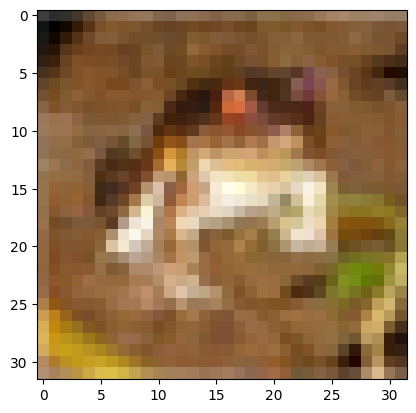

In [0]:
plt.imshow(x_train[0])

In [0]:
info_df = pd.DataFrame(index = ["Train data", "Test data"], columns=["Length", "Dimension", "Nb Classes"])

train_n_test = [(x_train, y_train), (x_test, y_test)]
lengths = []
dims = []
classes = []

for i in range(len(train_n_test)):
    lengths.append(len(train_n_test[i][0]))
    dims.append(train_n_test[i][0][0].shape)
    classes.append(len(np.unique(train_n_test[i][1])))

info_df["Length"] = lengths
info_df["Dimension"] = dims
info_df["Nb_Classes"] = classes

info_df.head()

Length    Dimension Nb Classes  Nb_Classes
Train data   50000  (32, 32, 3)        NaN          10
Test data    10000  (32, 32, 3)        NaN          10

## Clouds

In [0]:
data_dir = 'clouds'
img_name = '0011165.jpg'

In [0]:
image_path = data_dir + '/' + img_name
display.display(Image.open(str(image_path)))

Output hidden; open in https://colab.research.google.com to view.

In [0]:
img_t = plt.imread(image_path)

Size of a cloud image is:  (1400, 2100, 3)


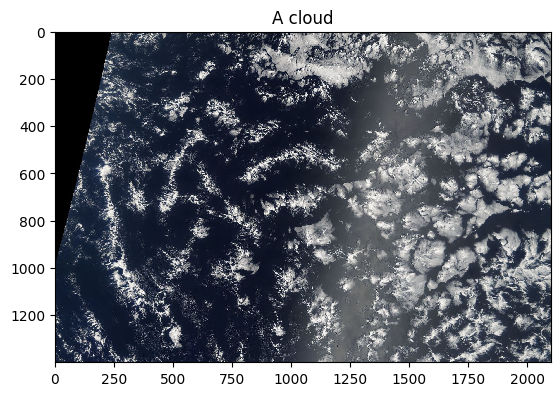

In [0]:
plt.title("A cloud")
plt.imshow(img_t);
print("Size of a cloud image is: ",img_t.shape)

In [0]:
image_count = len(os.listdir(data_dir))
print('Total images: ', image_count)

Total images:  40


In [0]:
image_names = os.listdir(data_dir)
image_names[:4]

['002be4f.jpg', '0035239.jpg', '00dec6a.jpg', '00498ec.jpg']

# Auxialry functions

In [0]:
def one_hot(ys):

    N = len(ys)
    nb_classes = len(np.unique(ys))
    y_new = np.zeros((N, nb_classes))
    y_new[np.arange(0, N), ys[:,0]] = 1

    return y_new

def load_images(data_dir, target_shape, proc=True):
    image_tensor = []

    for root, dirnames, filenames in os.walk(data_dir):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|png)$", filename):
                filepath = os.path.join(root, filename)
                image = Image.open(filepath)
                image_resized = np.array(image.resize((500, 500), Image.ANTIALIAS), dtype=float)
                if proc:
                    image_resized /= 255.
                image_tensor.append(image_resized)

    image_tensor = np.array(image_tensor)
    print("Tensor.shape: ", image_tensor.shape)
    return image_tensor

In [0]:
y_new = one_hot(y_train)

In [0]:
for i in range(10):
    k = int(np.random.random()*N)
    print("Normal: ", y_train[k+i])
    print("oNe Hot: ", y_new[k+i, :])

Normal:  [7]
oNe Hot:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Normal:  [3]
oNe Hot:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Normal:  [4]
oNe Hot:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Normal:  [6]
oNe Hot:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Normal:  [6]
oNe Hot:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Normal:  [2]
oNe Hot:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Normal:  [6]
oNe Hot:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Normal:  [2]
oNe Hot:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Normal:  [4]
oNe Hot:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Normal:  [2]
oNe Hot:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# Part I - Experiments

## Models

In [0]:
target_shape = (500, 500)
clouds = load_images(data_dir, target_shape)

Tensor.shape:  (40, 500, 500, 3)


In [0]:
from keras.applications.resnet import ResNet50

In [0]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape = clouds[0].shape)













94773248/94765736 [==============================] - 4s 0us/step


In [0]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 506, 506, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 250, 250, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 250, 250, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## SHOW ME WHAT YOU GOT

In [0]:
layer_outputs = []
for layer in conv_base.layers:
    if re.search("(_out)", layer.name):
        print(layer.name)
        layer_outputs.append(layer.output)

conv2_block1_out
conv2_block2_out
conv2_block3_out
conv3_block1_out
conv3_block2_out
conv3_block3_out
conv3_block4_out
conv4_block1_out
conv4_block2_out
conv4_block3_out
conv4_block4_out
conv4_block5_out
conv4_block6_out
conv5_block1_out
conv5_block2_out
conv5_block3_out


In [0]:
layer_outputs = [layer.output for layer in conv_base.layers if re.search("(_out)", layer.name)]
activation_model = models.Model(inputs = conv_base.input, outputs =  layer_outputs)
activation_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 506, 506, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 250, 250, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 250, 250, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

array([[0.09, 0.13, 0.25],
       [0.07, 0.12, 0.24],
       [0.07, 0.11, 0.23],
       ...,
       [0.66, 0.68, 0.73],
       [0.46, 0.49, 0.57],
       [0.3 , 0.33, 0.4 ]])

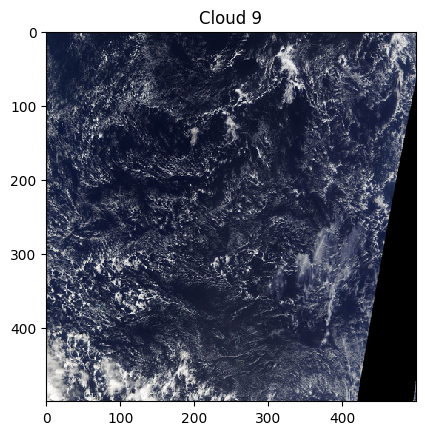

In [0]:
cloud9 = clouds[8, : , :, :]
plt.title("Cloud 9")
plt.imshow(cloud9);
cloud9[0, :, :]

In [0]:
activations = activation_model.predict(cloud9[np.newaxis, :, :, :])

In [0]:
activations[5].shape

(1, 63, 63, 512)

In [0]:
total_layers = len(activations)
total_layers

16

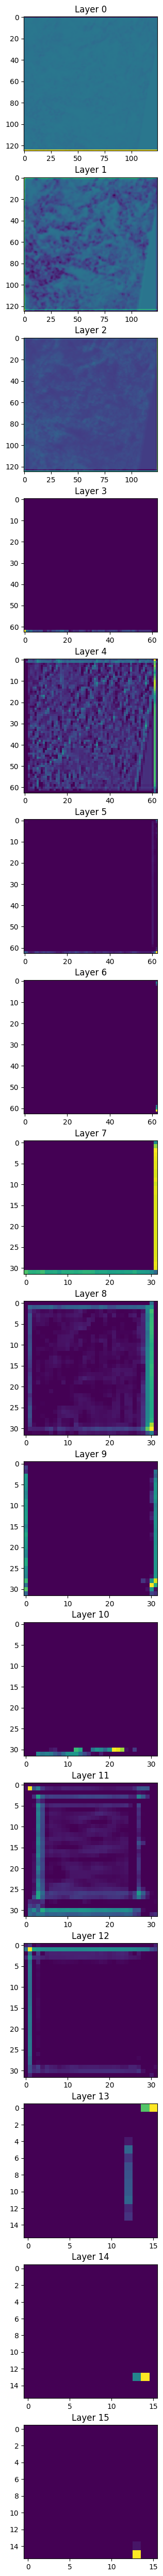

In [0]:
plots_per_layer = 1
fig, axs = plt.subplots(total_layers, 1, figsize = (4, total_layers*4))

for i in range(total_layers):
    current_layer = activations[i]
    rp = int(np.random.uniform(0, current_layer.shape[-1]))
    axs[i].set_title("Layer {:d}".format(i))
    axs[i].imshow(current_layer[0, :, :, rp], cmap='viridis')

In [0]:
layer5 = activations[4]
layer5.shape

(1, 63, 63, 512)

In [0]:
layer_names = []
for layer in activation_model.layers:
    layer_names.append(layer.name)

images_per_row = 5

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]

            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize = (scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')





Output hidden; open in https://colab.research.google.com to view.

## Get pattern

In [0]:
!unzip train.csv.zip -d clouds

Archive:  train.csv.zip
replace clouds/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
with open('clouds/train.csv', 'r') as readFile:
    train_csv = csv.reader(readFile)
    train_csv = list(train_csv)

In [0]:
ex = train_csv[1]
ex

['0011165.jpg_Fish',
 '264918 937 266318 937 267718 937 269118 937 270518 937 271918 937 273318 937 274718 937 276118 937 277518 937 278918 937 280318 937 281718 937 283118 937 284518 937 285918 937 287318 937 288718 937 290118 937 291518 937 292918 937 294318 937 295718 937 297118 937 298518 937 299918 937 301318 937 302718 937 304118 937 305518 937 306918 937 308318 937 309718 937 311118 937 312518 937 313918 937 315318 937 316718 937 318118 937 319518 937 320918 937 322318 937 323718 937 325118 937 326518 937 327918 937 329318 937 330718 937 332118 937 333518 937 334918 937 336318 937 337718 937 339118 937 340518 937 341918 937 343318 937 344718 937 346118 937 347518 937 348918 937 350318 937 351718 937 353118 937 354518 937 355918 937 357318 937 358718 937 360118 937 361518 937 362918 937 364318 937 365718 937 367118 937 368518 937 369918 937 371318 937 372718 937 374118 937 375518 937 376918 937 378318 937 379718 937 381118 937 382518 937 383918 937 385318 937 386718 937 388118 93

In [0]:
a_cloud = ex[0][:(len(ex[0])-5)]
fish = ex[0][(len(ex[0])-4):]
print("Image is ", a_cloud)
print("Pattern is ", fish)

Image is  0011165.jpg
Pattern is  Fish


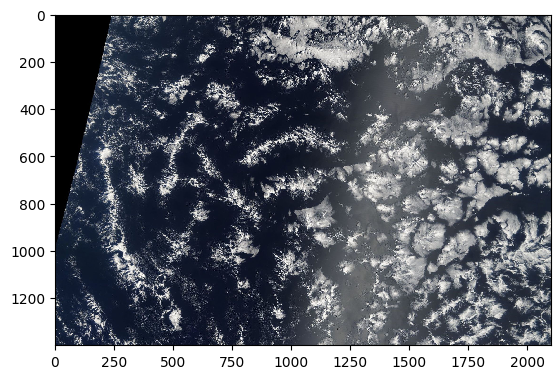

In [0]:
img = plt.imread('clouds/'+a_cloud)
plt.imshow(img);

In [0]:
pattern_img = np.zeros(img.shape[0]*img.shape[1]*img.shape[2]).astype('float32')
img_flat = img.flatten()
pixels = ex[1].split(' ')
for i, pix in enumerate(pixels[:]):
    pattern_img[int(pix)] = 1

fish_pat = pattern_img.reshape(img.shape)
fish_pat = np.mean(fish_pat, axis = 2)
fish_pat.shape

(1400, 2100)

In [0]:
N = 500
mins = np.zeros(N)
maxs = np.zeros(N)
for row in range(N):
    not_null = np.where(fish_pat[row, :] > 0)[0]
    print(not_null)
    if len(not_null) > 1:
        mins[row] = np.min(not_null)
        maxs[row] = np.max(not_null)

[ 56 112 149 162 199 256 312]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 1039 1506 1972]
[ 339  806 1272 1739]
[ 106  572 103

In [0]:
img2 = np.mean(img, axis=2)
print(img2.shape)
fish_extr = np.zeros_like(img2)
for i in range(N):
    fish_extr[i, int(mins[i]):int(maxs[i])] = img2[i, int(mins[i]):int(maxs[i])]


(1400, 2100)


In [0]:
plt.title("Fish pattern ?")
#plt.imshow(np.mean(img, axis=2));
plt.imshow(fish_extr);

'2'

## Cifar stuff

In [0]:
def transfer_model(feat_extractor, nb_dense, nb_classes):

    model = models.Sequential()

    model.add(feat_extractor)
    model.add(layers.Flatten())
    model.add(layers.Dense(nb_dense, activation='relu'))
    model.add(layers.Dense(nb_classes, activation='softmax'))
    return model

In [0]:
m = transfer_model(conv_base, 500, 10)

In [0]:
len(m.trainable_weights)

216

In [0]:
conv_base.trainable = False

In [0]:
len(m.trainable_weights)

4

In [0]:
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               204900    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 23,793,622
Trainable params: 205,910
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
m.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [0]:
history = m.fit(x_train, y_new, batch_size = 200, epochs = 20,
                validation_split = 0.2)



Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 16s 394us/step - loss: 0.3252 - acc: 0.8947 - val_loss: 0.4282 - val_acc: 0.8676
Epoch 2/20
40000/40000 [==============================] - 6s 154us/step - loss: 0.2644 - acc: 0.9045 - val_loss: 0.4772 - val_acc: 0.8612
Epoch 3/20
40000/40000 [==============================] - 6s 152us/step - loss: 0.2454 - acc: 0.9093 - val_loss: 0.5190 - val_acc: 0.8575
Epoch 4/20
40000/40000 [==============================] - 6s 153us/step - loss: 0.2334 - acc: 0.9128 - val_loss: 0.5974 - val_acc: 0.8511
Epoch 5/20
40000/40000 [==============================] - 6s 153us/step - loss: 0.2243 - acc: 0.9152 - val_loss: 0.6013 - val_acc: 0.8521
Epoch 6/20
40000/40000 [==============================] - 6s 154us/step - loss: 0.2168 - acc: 0.9177 - val_loss: 0.5953 - val_acc: 0.8533
Epoch 7/20
40000/40000 [==============================] - 6s 154us/step - loss: 0.2103 - acc: 0.9197 - val_loss: 0.6110

## Fourier

## Wavelets

array([[0.09, 0.13, 0.25],
       [0.07, 0.12, 0.24],
       [0.07, 0.11, 0.23],
       ...,
       [0.66, 0.68, 0.73],
       [0.46, 0.49, 0.57],
       [0.3 , 0.33, 0.4 ]])

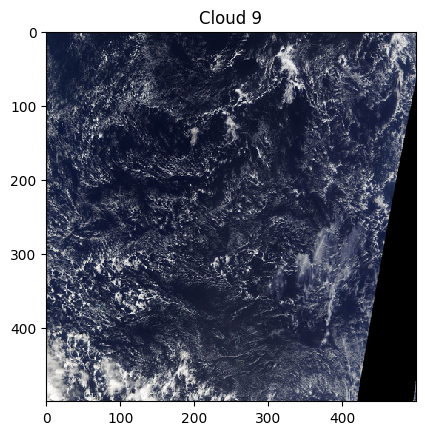

In [0]:
cloud9 = clouds[8, : , :, :]
plt.title("Cloud 9")
plt.imshow(cloud9);
cloud9[0, :, :]

In [0]:
c9 = np.mean(cloud9, axis=2)

In [0]:
plt.title("Cloud 9")
plt.imshow(c9, cmap='viridis');

In [0]:
(cA, (cH, cV, cD)) = pywt.wavedec2(c9, 'haar', level=1)

In [0]:
cA.shape,cH.shape,cV.shape,cD.shape

((250, 250), (250, 250), (250, 250), (250, 250))

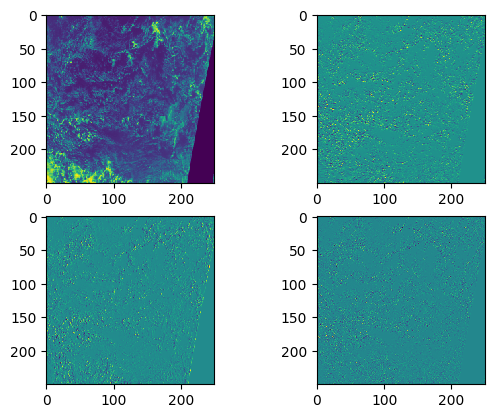

In [0]:
fig,axs=plt.subplots(2,2)
axs[0,0].imshow(cA,cmap='viridis')
axs[0,1].imshow(cH,cmap='viridis')
axs[1,0].imshow(cV,cmap='viridis')
axs[1,1].imshow(cD,cmap='viridis');

In [0]:
print(pywt.wavelist())

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'shan', 'sym2', 'sym3

In [0]:
coeffs = pywt.wavedec2(c9, 'db3', level=3)

In [0]:
plt.imshow(coeffs[0],cmap='viridis');

In [0]:
fig,axs=plt.subplots(3, 3)

for i in range(1, 4):
    for j in range(3):
        axs[i-1,j].imshow(coeffs[i][j], cmap='viridis')

## Chirp signal example

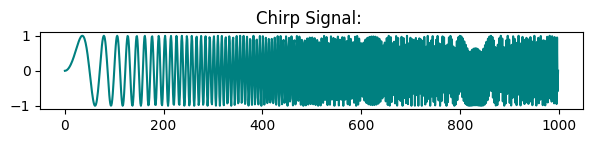

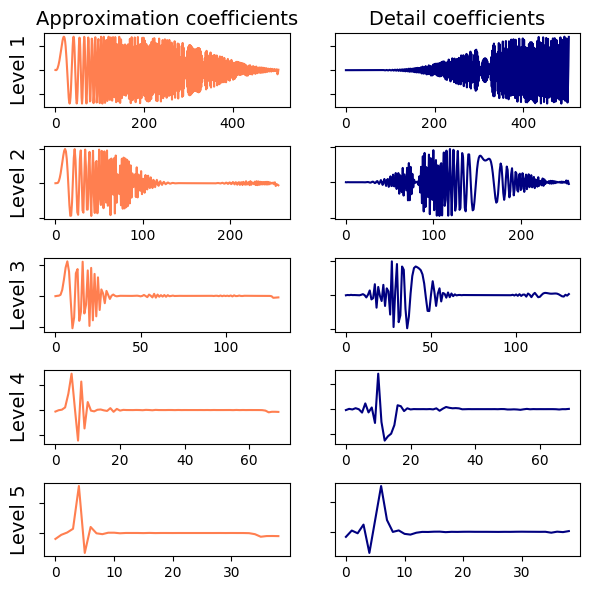

In [0]:
x = np.linspace(0, 1, 1000)
chirp = np.sin(400 * np.pi *  x**2)

fig, ax = plt.subplots(figsize=(7,1))
ax.set_title("Chirp Signal: ")
ax.plot(chirp, color = 'teal')
plt.show()
    
waveletname = 'sym5'
data = chirp.copy()
 
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for i in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axs[i, 0].plot(data, color = 'coral')
    axs[i, 1].plot(coeff_d, color = 'navy')
    axs[i, 0].set_ylabel("Level {}".format(i + 1), fontsize=14, rotation=90)
    axs[i, 0].set_yticklabels([])
    if i == 0:
        axs[i, 0].set_title("Approximation coefficients", fontsize=14)
        axs[i, 1].set_title("Detail coefficients", fontsize=14)
    axs[i, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

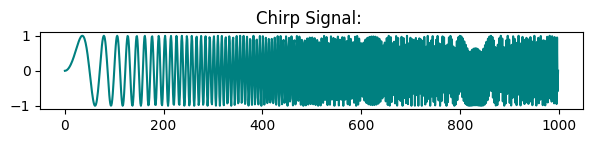

In [0]:
x = np.linspace(0, 1, 1000)
chirp = np.sin(400 * np.pi *  x**2)

fig, ax = plt.subplots(figsize=(7,1))
ax.set_title("Chirp Signal: ")
ax.plot(chirp, color = 'teal')
plt.show()
    
waveletname = 'sym5'
decomp = pywt.wavedec(chirp, waveletname, level=5)
len(decomp)
 
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(6,6))
for i in range(6):
    if i == 0:
        axs[i].set_title("Approximation coefficients", fontsize=14)
        axs[i].plot(decomp[i], color = 'coral')
    elif i == 1:
        axs[i].set_title("Detail coefficients", fontsize=14)
        axs[i].plot(decomp[-i], color = 'navy')
        axs[i].set_ylabel("Level {}".format(i), fontsize=14, rotation=90)
    else:
        axs[i].plot(decomp[-i], color = 'navy')
        axs[i].set_ylabel("Level {}".format(i), fontsize=14, rotation=90)
        
    axs[i].set_yticklabels([])
plt.tight_layout()
plt.show()

In [0]:
def weird_haar(t):
    r = np.zeros_like(t)
    t0 = t - np.floor(t)
    r[t0>0.5] = -1
    r[t0<=0.5] = 1
    return r

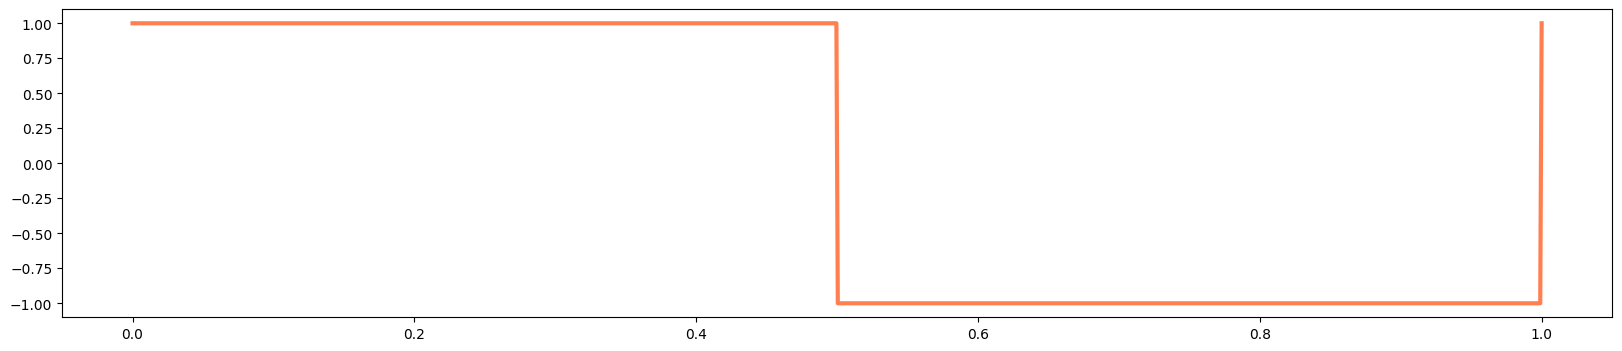

In [15]:
fig, axs = plt.subplots(1, 1, figsize = (20, 4))
t = np.linspace(0, 1, 1000)
axs.plot(t, weird_haar(t), linewidth = 3, color = 'coral')

In [12]:
t - np.floor(t)


array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51, 0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96, 0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51, 0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96, 0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51, 0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96, 0.01, 0.06, 0.11, 0.16, 0.21, 0.2